# Importing Relevant Libraries

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
import time
import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision


import requests
from io import BytesIO
import torch 
import cv2
from matplotlib.colors import LinearSegmentedColormap

!pip install captum
!pip install lime
from lime import lime_image
from captum.attr import visualization as viz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 6.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 6.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=f9c337ad6e8b34b84ea052324909fadc652c228f1262f99cf53dfef94f452c22
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [3]:
from captum.metrics import sensitivity_max

# Getting pretrained model and classes 

In [4]:
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [5]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [6]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [7]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2022-12-20 10:50:35--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.197.56, 52.217.163.48, 54.231.137.64, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.197.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/root/.torch/models/imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.06s   

2022-12-20 10:50:35 (560 KB/s) - ‘/root/.torch/models/imagenet_class_index.json’ saved [35363/35363]



In [9]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [11]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}  

In [12]:
img = Image.open("happy.jpg")

In [13]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [14]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.7110731, 207, 'golden_retriever'),
 (0.10797543, 208, 'Labrador_retriever'),
 (0.044754766, 209, 'Chesapeake_Bay_retriever'),
 (0.037000638, 211, 'vizsla'),
 (0.020191396, 163, 'bloodhound'))

In [15]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


In [16]:
test_pred = batch_predict([pill_transf(img)])
target=int(test_pred.squeeze().argmax())


In [17]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 
])

transform_normalize =transforms.Compose([
    transforms.ToTensor(),               # converts the image to a tensor with values between 0 and 1
    transforms.Normalize(                # normalize to follow 0-centered imagenet pixel rgb distribution
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
    )
])

img = Image.open('happy.jpg')

transformed_img = transform_normalize(img)

input_img = transform_normalize(transform(img)).unsqueeze(0)

In [18]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: golden_retriever ( 0.711073100566864 )


# Attribution Based Methods for Image Classification

### Occlusion Based Method


In [22]:
from captum.attr import Occlusion 
st = time.time()
occlusion = Occlusion(model)

attributions_dog = occlusion.attribute(input_img,
                                       strides = (3, 8, 8),
                                       target=target,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)
end = time.time()
print(end-st)

74.29191589355469


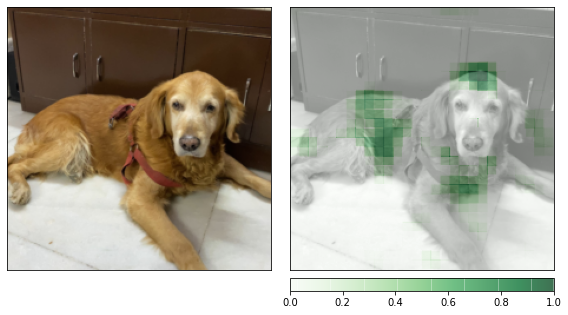

In [20]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_dog.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(transform(img)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

In [ ]:
# sens = sensitivity_max(occlusion.attribute, input_img, target = target,sliding_window_shapes=(3,15, 15))

In [25]:
# sens

tensor([0.1300])

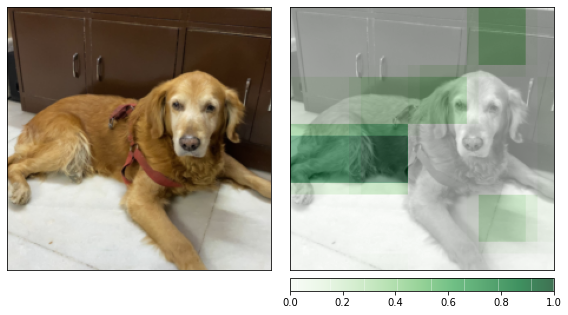

In [21]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_img,
                                       strides = (3, 50, 50),
                                       target=target,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(transform(img)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

### Integrated Gradients and Integrated Gradients with SmoothGrad

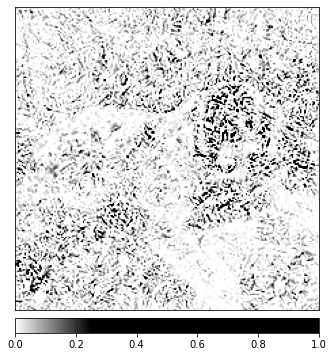

41.498878717422485


In [27]:
from captum.attr import IntegratedGradients 
st= time.time()
ig = IntegratedGradients(model)

strides = (3, 9, 9)               # smaller = more fine-grained attribution but slower
sliding_window_shapes=(3,45, 45)  # choose size enough to change object appearance
baselines = input                     # values to occlude the image with. 0 corresponds to gray

attribution_dog = ig.attribute(input_img,
                                       target=target,n_steps = 200)


end = time.time()
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attribution_dog.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)
print(end-st)

In [35]:
sens = sensitivity_max(ig.attribute, input_img, target = target)

In [37]:
sens

tensor([0.4889], dtype=torch.float64)

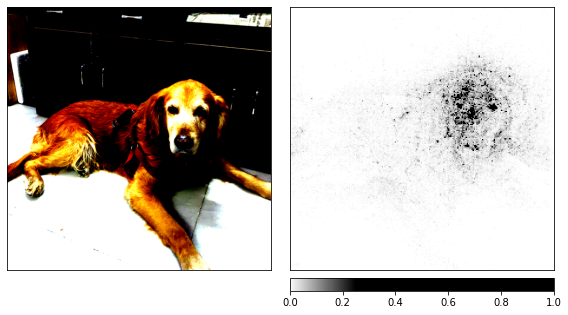

84.5543909072876


In [23]:
from captum.attr import NoiseTunnel
st = time.time()
noise_tunnel = NoiseTunnel(occlusion)
attributions_ig_nt = noise_tunnel.attribute(input_img, nt_samples=10, nt_type='smoothgrad_sq', target=target)
end = time.time()
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

print(end-st)

In [ ]:
# sens = sensitivity_max(noise_tunnel.attribute, input_img, target = target)

In [4]:
#sens

tensor([0.1600])

### Guided Grad-CAM

/usr/local/lib/python3.8/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


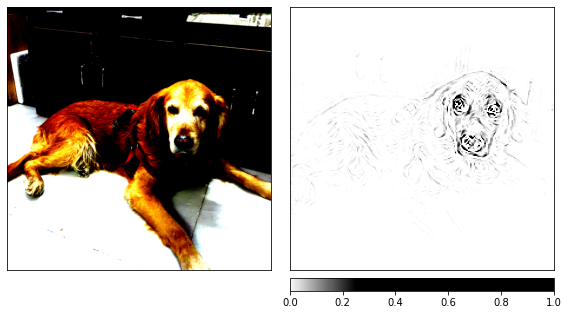

0.2997856140136719


In [25]:
from captum.attr import GuidedGradCam
st = time.time()
Gradcam = GuidedGradCam(model,model.layer4)

for module in model.modules():
  if isinstance(module,torch.nn.ReLU):
    module.inplace = False

attributions_gradcam = Gradcam.attribute(input_img, target=target)
end = time.time()
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gradcam.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)
print(end-st)

In [31]:
sens = sensitivity_max(Gradcam.attribute, input_img, target = target)

/usr/local/lib/python3.8/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


In [32]:
sens

tensor([0.1255])

### LIME Implementation


  0%|          | 0/1000 [00:00<?, ?it/s]

85.97559523582458


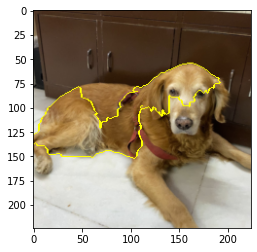

In [21]:
st = time.time()
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
# Let's use mask on image and see the areas that are encouraging the top prediction.
end = time.time()
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)
print(end-st)

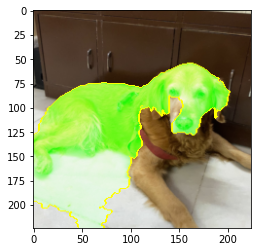

In [18]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

tensor([0.0400])